# Fisher examples

In this notebook we will show how to perform Fisher analysis for galaxy clustering.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake BAO experiment

[000000.01] [0/1] 01-19 09:48  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000000.01] [0/1] 01-19 09:48  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.01] [0/1] 01-19 09:48  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000000.01] [0/1] 01-19 09:48  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000000.01] [0/1] 01-19 09:48  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo-1.0.0-py3.9.egg/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))
/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/numpy/lib/polynomial.py:1329: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


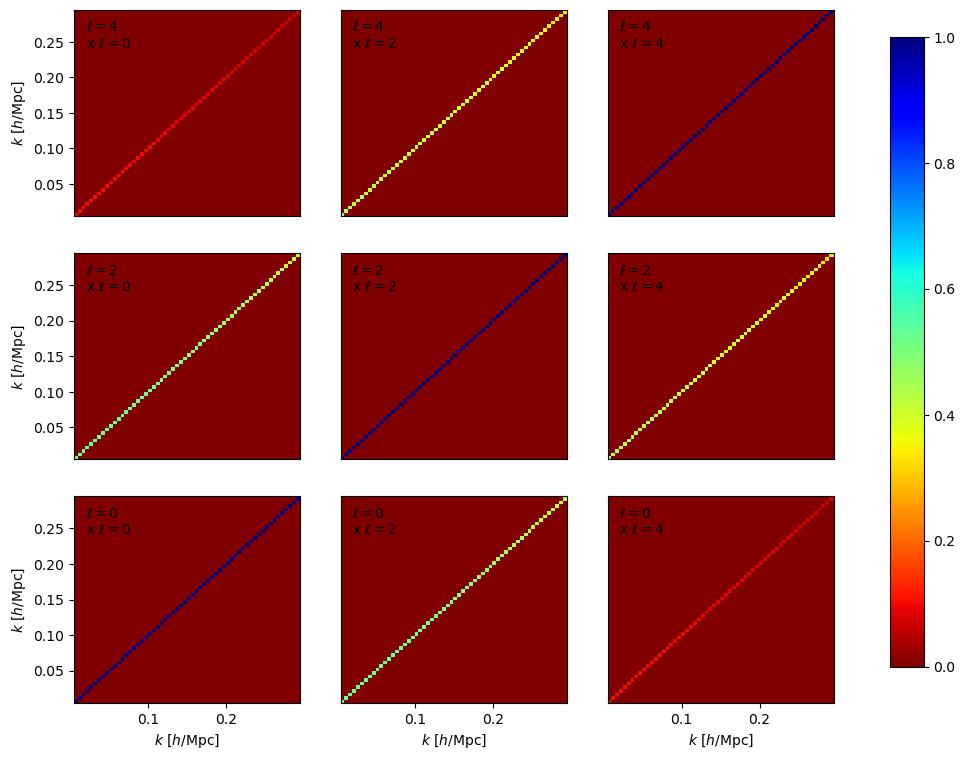

In [1]:
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable, CutskyFootprint, ObservablesCovarianceMatrix
from desilike.likelihoods.galaxy_clustering import ObservablesGaussianLikelihood
from desilike import setup_logging

params = {'b1': 1.4}
footprint = CutskyFootprint(area=14000., zrange=(0.8, 1.6), nbar=(1e-3, 1e-3), cosmo=DESI())
template = BAOPowerSpectrumTemplate(z=footprint.zavg, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template)
#for param in theory.params.select(basename='a*'): param.update(fixed=True)
observable = TracerPowerSpectrumMultipolesObservable(data=params,  # data can be a dictionary of parameters
                                                     klim={0: [0.005, 0.3], 2: [0.005, 0.3], 4: [0.005, 0.3]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     kstep=0.005, theory=theory)


setup_logging()
covariance = ObservablesCovarianceMatrix(observable, footprints=footprint, resolution=5)
likelihood = ObservablesGaussianLikelihood(observables=observable, covariance=covariance(**params))
likelihood(**params)

observable.plot_covariance_matrix(show=True);

In [2]:
from desilike import Fisher

fisher = Fisher(likelihood)
print(likelihood.all_params.select(derived=True))
precision_bao = fisher(**params)

[000006.99] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-3', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al2_-3', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al4_-3', 'al4_-2', 'al4_-1', 'al4_0', 'al4_1'].
[000007.15] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter qpar.
[000007.19] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter qper.
[000007.26] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000007.30] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-3.
[000007.33] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-2.
[000007.37] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-1.
[000007.41] [0/1] 01-19 09:48  Differentiation           INFO    

+-----+----------+
| FoM | 40062.04 |
+-----+----------+
+--------+--------+--------+
|        |  qpar  |  qper  |
+--------+--------+--------+
| center | 1.0000 | 1.0000 |
|  std   | 0.0075 | 0.0037 |
+--------+--------+--------+
+------+---------+---------+
|      |  qpar   |  qper   |
+------+---------+---------+
| qpar | 5.6e-5  | -1.1e-5 |
| qper | -1.1e-5 | 1.3e-5  |
+------+---------+---------+
[000011.76] [0/1] 01-19 09:48  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
[000012.18] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000012.18] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


[000012.42] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000012.42] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


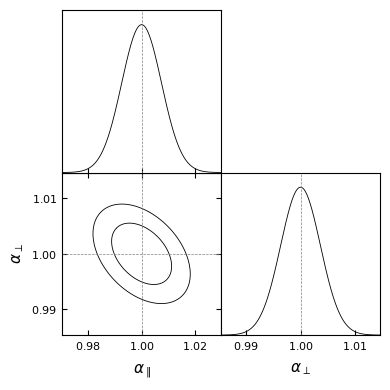

In [3]:
from desilike.samples import plotting
covariance = precision_bao.to_covariance().select(params=['qpar', 'qper'])
print(covariance.to_stats(tablefmt='pretty'))
plotting.plot_triangle(covariance, markers={'qpar': 1., 'qper': 1.})

[000012.89] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000012.89] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


[000013.15] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000013.16] [0/1] 01-19 09:48  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


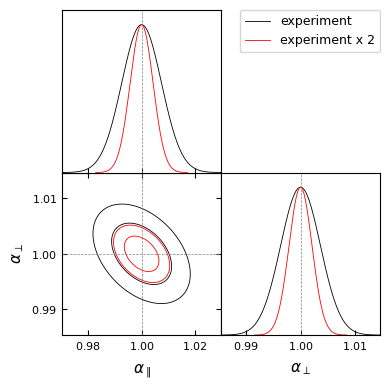

In [4]:
# One can do some fisher arithmetics, here assuming we have two independents such experiments
covariance2 = (precision_bao + precision_bao).to_covariance(params=['qpar', 'qper'])
plotting.plot_triangle([covariance, covariance2],
                        labels=['experiment', 'experiment x 2'],
                        markers={'qpar': 1., 'qper': 1.})

In [5]:
from desilike.observables.galaxy_clustering import BAOCompression
from desilike.theories.primordial_cosmology import Cosmoprimo

cosmo = Cosmoprimo(fiducial='DESI')
observable = BAOCompression(covariance=covariance, z=footprint.zavg, cosmo=cosmo)
for param in cosmo.varied_params.select(basename=['A_s', 'n_s']): param.update(fixed=True)
likelihood = ObservablesGaussianLikelihood(observables=observable)
likelihood()
    
fisher = Fisher(likelihood)
precision_bao_direct = fisher()

[000013.56] [0/1] 01-19 09:48  BAOCompression            INFO     Found BAO quantities ['qpar', 'qper'].
[000013.81] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA'].
[000013.82] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter h.
[000013.83] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter omega_cdm.
[000013.85] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter omega_b.
[000013.86] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter logA.
[000013.87] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA'].
[000014.04] [0/1] 01-19 09:48  Differentiation           INFO     Using finite-differentiation for parameter h.
[000014.11] [0/1] 01-19 09:48  Differentiation           INFO     Using finite

## CMB experiment
Let's consider the Planck CMB data.

In [6]:
from desilike.likelihoods.cmb import BasePlanck2018GaussianLikelihood

cosmo = Cosmoprimo(fiducial='DESI')
likelihood = BasePlanck2018GaussianLikelihood(cosmo=cosmo)
# Install Planck likelihoods (clik + data)
from desilike import Installer
installer = Installer(user=True)
installer(likelihood)
likelihood()

[000015.08] [0/1] 01-19 09:48  ParameterCovariance       INFO     Loading stats file: /home/adematti/.local/data/BasePlanck2018GaussianLikelihood/base/plikHM_TTTEEE_lowl_lowE_lensing/dist/base_plikHM_TTTEEE_lowl_lowE_lensing.margestats.
[000015.09] [0/1] 01-19 09:48  Install                   INFO     Requirement already satisfied: cosmoprimo in /home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/cosmoprimo-1.0.0-py3.9.egg
[000015.09] [0/1] 01-19 09:48  BaseConfig                INFO     Saving /home/adematti/.desilike/config.yaml.


DeviceArray(-1.27606044, dtype=float64)

In [7]:
fisher = Fisher(likelihood)
precision_planck = fisher()

[000015.63] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[000015.65] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter h.
[000015.66] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter omega_cdm.
[000015.68] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter omega_b.
[000015.70] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter logA.
[000015.71] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter n_s.
[000015.72] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[000015.75] [0/1] 01-19 09:48  Differentiation           INFO     Using finite-differentiation for parameter h.
[000015.79] [0/1] 01-19 09:48  Differentiation           

+-----+--------------------+
| FoM | 514220691865400.06 |
+-----+--------------------+
+--------+--------+-----------+---------+--------+--------+
|        |   h    | omega_cdm | omega_b |  logA  |  n_s   |
+--------+--------+-----------+---------+--------+--------+
| center | 0.6736 |  0.1200   | 0.02237 | 3.0364 | 0.9649 |
|  std   | 0.0049 |  0.0011   | 0.00014 | 0.0054 | 0.0039 |
+--------+--------+-----------+---------+--------+--------+
+-----------+---------+-----------+---------+---------+---------+
|           |    h    | omega_cdm | omega_b |  logA   |   n_s   |
+-----------+---------+-----------+---------+---------+---------+
|     h     | 2.4e-5  |  -5.0e-6  | 4.6e-7  | -7.2e-6 | 1.2e-5  |
| omega_cdm | -5.0e-6 |  1.2e-6   | -7.1e-8 | 1.9e-6  | -2.6e-6 |
|  omega_b  | 4.6e-7  |  -7.1e-8  | 2.0e-8  | -3.2e-8 | 1.8e-7  |
|   logA    | -7.2e-6 |  1.9e-6   | -3.2e-8 | 3.0e-5  | -5.3e-6 |
|    n_s    | 1.2e-5  |  -2.6e-6  | 1.8e-7  | -5.3e-6 | 1.5e-5  |
+-----------+---------+--

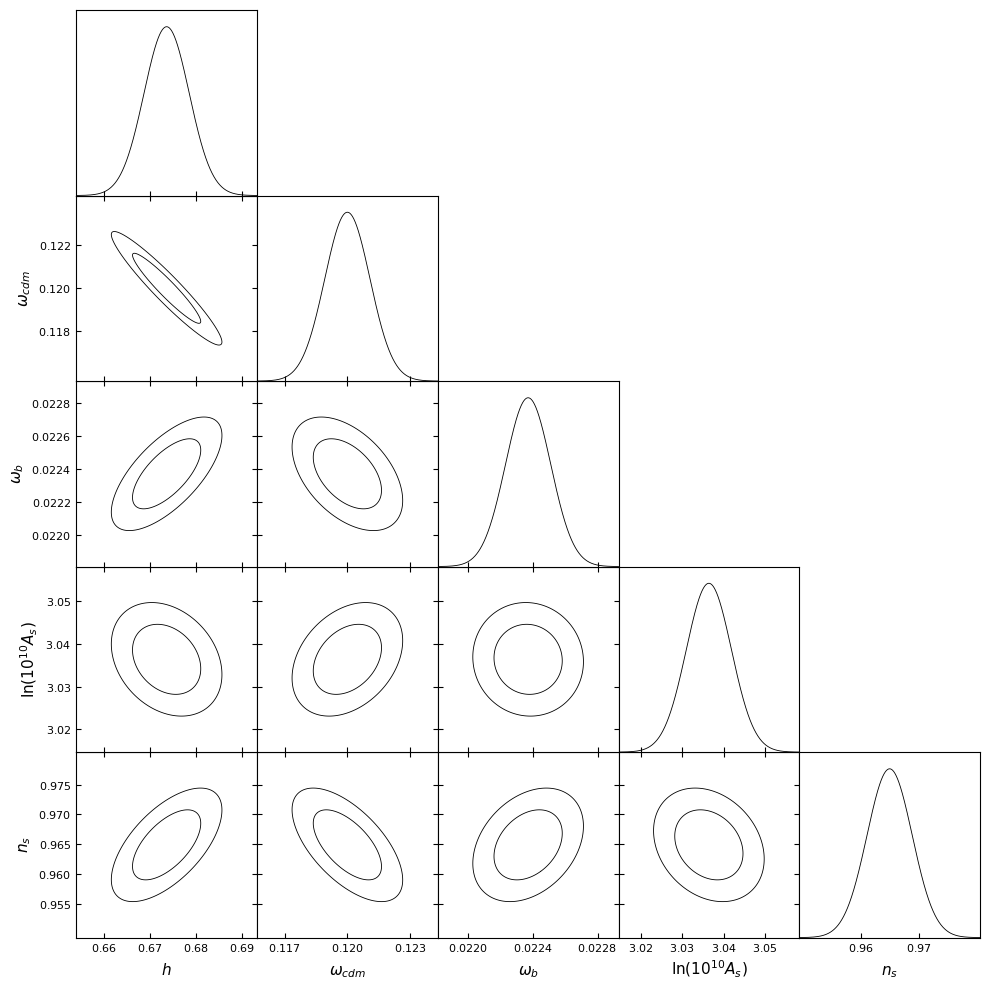

In [8]:
covariance = precision_planck.to_covariance()
print(covariance.to_stats(tablefmt='pretty'))
plotting.plot_triangle(precision_planck.to_covariance())

## Combining BAO and CMB experiments

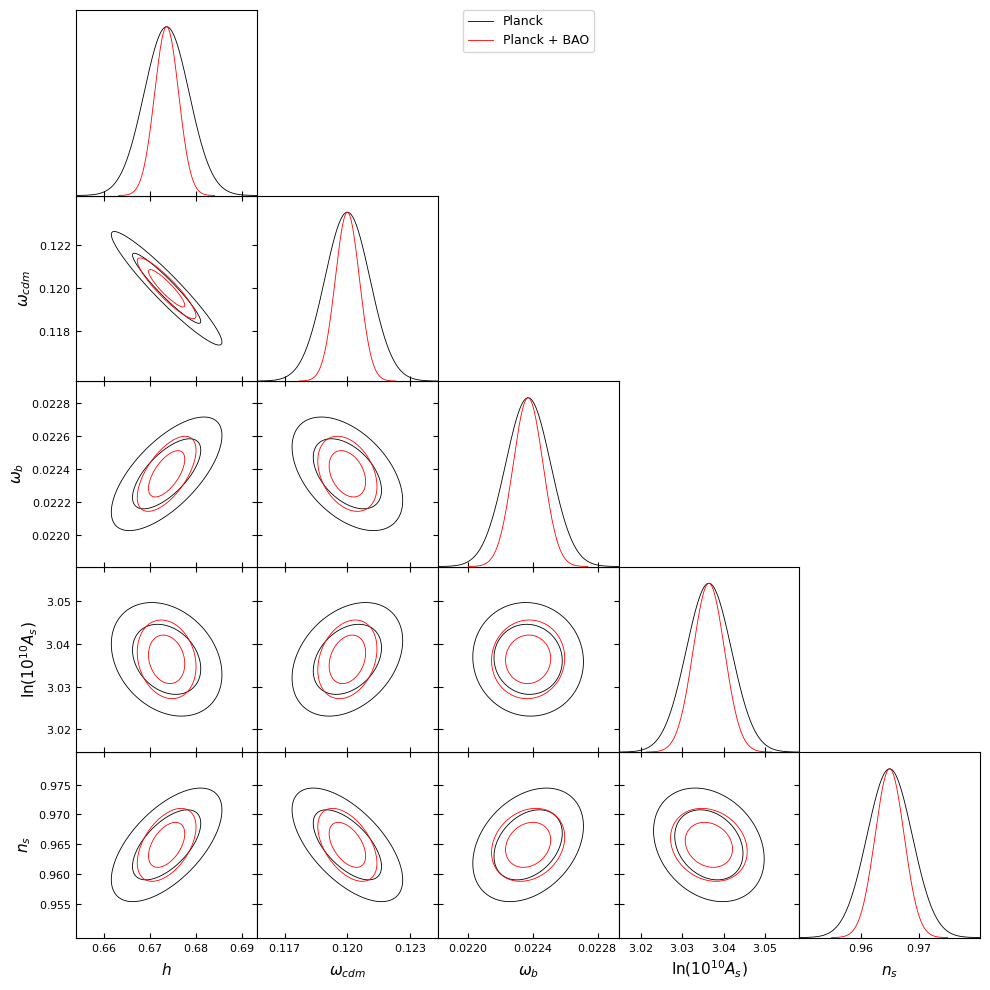

In [9]:
plotting.plot_triangle([precision_planck.to_covariance(), (precision_planck + precision_bao_direct).to_covariance()],
                       labels=['Planck', 'Planck + BAO'])

We have had very fast results, now we can run some checks!

## Comparing BAO experiment with ideal SN-weighted measurement

In [10]:
from desilike.likelihoods.galaxy_clustering import SNWeightedPowerSpectrumLikelihood

likelihood = SNWeightedPowerSpectrumLikelihood(theories=theory, data=params, footprints=footprint, klim=(0.005, 0.3))
fisher = Fisher(likelihood)
precision_bao2 = fisher(**params)

[000025.25] [0/1] 01-19 09:48  Differentiation           INFO     Varied parameters: ['qpar', 'qper', 'b1', 'al0_-3', 'al0_-2', 'al0_-1', 'al0_0', 'al0_1', 'al2_-3', 'al2_-2', 'al2_-1', 'al2_0', 'al2_1', 'al4_-3', 'al4_-2', 'al4_-1', 'al4_0', 'al4_1'].
[000025.29] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter qpar.
[000025.33] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter qper.
[000025.36] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000025.40] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-3.
[000025.44] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-2.
[000025.48] [0/1] 01-19 09:48  Differentiation           INFO     Using auto-differentiation for parameter al0_-1.
[000025.52] [0/1] 01-19 09:48  Differentiation           INFO    

[000068.26] [0/1] 01-19 09:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000068.26] [0/1] 01-19 09:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
SN-weighted constraints are tighter by 1.5%, 1.1% for qpar, qper.
[000068.52] [0/1] 01-19 09:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000068.53] [0/1] 01-19 09:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


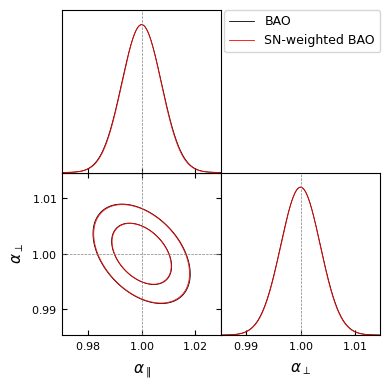

In [11]:
covariances = [precision.to_covariance(params=['qpar', 'qper']) for precision in [precision_bao, precision_bao2]]
plotting.plot_triangle(covariances, labels=['BAO', 'SN-weighted BAO'], markers={'qpar': 1., 'qper': 1.})
# We see SN-weighted constraints are slightly tighter
print('SN-weighted constraints are tighter by {0:.1%}, {1:.1%} for qpar, qper.'.format(*(covariances[0].std() / covariances[1].std() - 1.)))

## Comparing Planck covmat with clik

In [12]:
from desilike.likelihoods.cmb import TTTEEEHighlPlanck2018PlikLiteLikelihood, TTLowlPlanck2018ClikLikelihood,\
                                     EELowlPlanck2018ClikLikelihood, LensingPlanck2018ClikLikelihood 
from desilike.likelihoods import SumLikelihood

cosmo = Cosmoprimo(fiducial='DESI')
likelihoods = [Likelihood(cosmo=cosmo) for Likelihood in [TTTEEEHighlPlanck2018PlikLiteLikelihood, TTLowlPlanck2018ClikLikelihood,\
                                                          EELowlPlanck2018ClikLikelihood, LensingPlanck2018ClikLikelihood]]
likelihood_cmb = SumLikelihood(likelihoods=likelihoods)
# Install Planck likelihoods (clik + data)
# from desilike import Installer
# installer = Installer(user=True)
# installer(likelihood_cmb)
likelihood_cmb()

 Initializing Planck likelihood, version Plik_v22_cmbonly_like                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter loglikelihood of EELowlPlanck2018ClikLikelihood is already derived in LensingPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter logprior of EELowlPlanck2018ClikLikelihood is already derived in LensingPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter loglikelihood of TTLowlPlanck2018ClikLikelihood is already derived in EELowlPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter logprior of TTLowlPlanck2018ClikLikelihood is already derived in EELowlPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived p

DeviceArray(-517.11552646, dtype=float64)

In [13]:
fisher = Fisher(likelihood_cmb)
precision_planck2 = fisher()

[000078.87] [0/1] 01-19 09:49  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'A_planck'].
[000078.89] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter h.
[000078.92] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter omega_cdm.
[000078.93] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter omega_b.
[000078.96] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter logA.
[000078.98] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter n_s.
[000079.07] [0/1] 01-19 09:49  Differentiation           INFO     Using auto-differentiation for parameter A_planck.
[000085.87] [0/1] 01-19 09:49  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'A_planck'].
[000092.51] [0/1] 01-19 09:4

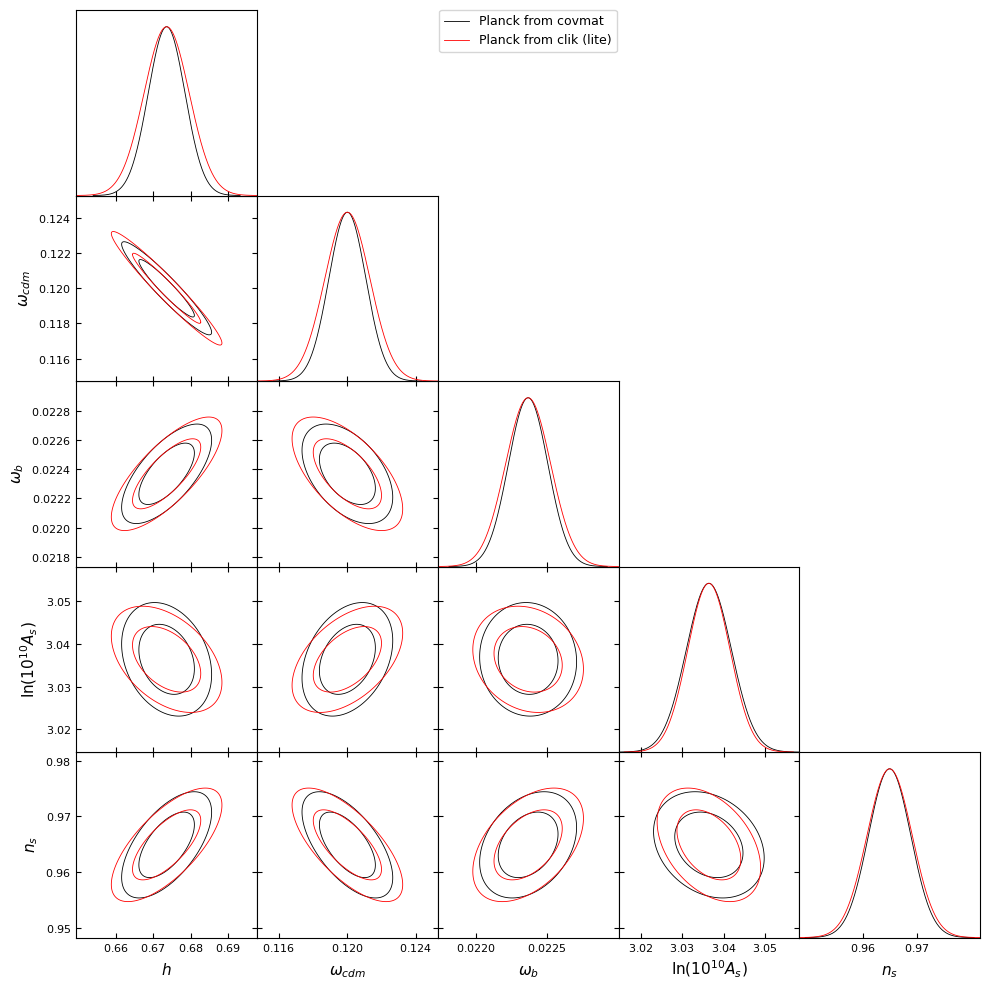

In [14]:
plotting.plot_triangle([precision_planck.to_covariance(), precision_planck2.to_covariance()],
                       labels=['Planck from covmat', 'Planck from clik (lite)'])

## Comparing CMB Fisher with chains

In [15]:
# Let us emulate theory Cl's to avoid running chains for hours
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

for likelihood in likelihoods:
    emulator = Emulator(likelihood.theory, engine=TaylorEmulatorEngine(order=1))
    emulator.set_samples()
    emulator.fit()
    likelihood.init.update(theory=emulator.to_calculator())

[001021.67] [0/1] 01-19 10:05  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[001021.67] [0/1] 01-19 10:05  Emulator                  INFO     Found varying ['tt', 'ee', 'te'] and fixed ['requested_cls', 'unit'] outputs.
[001021.68] [0/1] 01-19 10:05  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[001053.10] [0/1] 01-19 10:05  Differentiation           INFO     Using finite-differentiation for parameter h.
[001058.83] [0/1] 01-19 10:05  Differentiation           INFO     Using finite-differentiation for parameter omega_cdm.
[001064.49] [0/1] 01-19 10:06  Differentiation           INFO     Using finite-differentiation for parameter omega_b.
[001070.24] [0/1] 01-19 10:06  Differentiation           INFO     Using finite-differentiation for parameter logA.
[001076.02] [0/1] 01-19 10:06  Differentiation           INFO     Using finite-differentiation for parameter n_s.
[001162.59] [0/

In [16]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood_cmb, seed=42)
sampler.run(check={'max_eigen_gr': 0.05})

[001568.34] [0/1] 01-19 10:14  ZeusSampler               INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'A_planck'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter loglikelihood of EELowlPlanck2018ClikLikelihood is already derived in LensingPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter logprior of EELowlPlanck2018ClikLikelihood is already derived in LensingPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter loglikelihood of TTLowlPlanck2018ClikLikelihood is already derived in EELowlPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived parameter logprior of TTLowlPlanck2018ClikLikelihood is already derived in EELowlPlanck2018ClikLikelihood.
  warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:133: UserWarning: Derived p

[001569.37] [0/1] 01-19 10:14  root                      INFO     Initialising ensemble of 16 walkers...
[002361.95] [0/1] 01-19 10:27  ZeusSampler               INFO     Diagnostics:
[002361.96] [0/1] 01-19 10:27  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.115; not < 0.05.
[002361.96] [0/1] 01-19 10:27  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.0632.
[002361.98] [0/1] 01-19 10:27  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.265.
[002361.99] [0/1] 01-19 10:27  ZeusSampler               INFO     - max Geweke is 0.318.
[002361.99] [0/1] 01-19 10:27  ZeusSampler               INFO     - Geweke p-value is 0.401.
[002362.01] [0/1] 01-19 10:27  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 18.5.
[002362.53] [0/1] 01-19 10:27  root                      INFO     Initialising ensemble of 16 walkers...
[003139.99] [0/1] 01-19 10:40  ZeusSampler               INFO

[008454.06] [0/1] 01-19 12:09  ZeusSampler               INFO     - Geweke p-value is 0.276.
[008454.09] [0/1] 01-19 12:09  ZeusSampler               INFO     - (1350 iterations / integrated autocorrelation time) (reliable) is 102.
[008454.09] [0/1] 01-19 12:09  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0463.


Removed no burn in


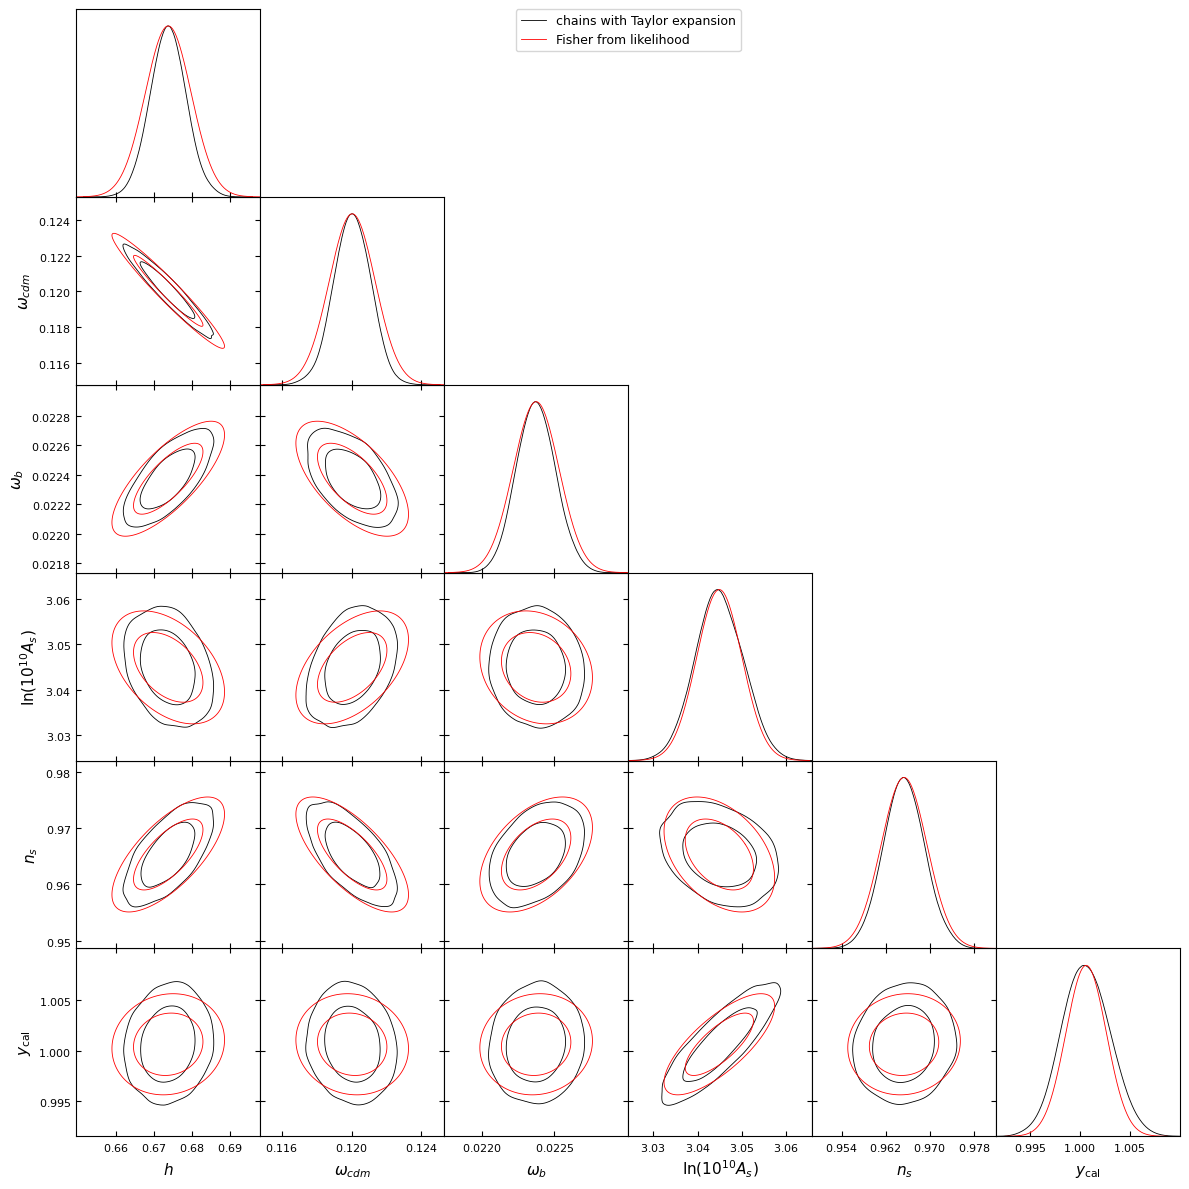

In [23]:
samples = sampler.chains[0].remove_burnin(0.5)
covariance = precision_planck2.to_covariance()
# ln(10^{10}A_s) of 'DESI' fiducial is ln(10^10 2.0830e-9), which is not the center of Planck likelihoods
# hack: move Fisher so it appeared centered
# TODO: understand the difference
covariance = covariance.clone(center=samples.mean(covariance.params()))
plotting.plot_triangle([samples, covariance],
                       labels=['chains with Taylor expansion', 'Fisher from likelihood'])

Removed no burn in


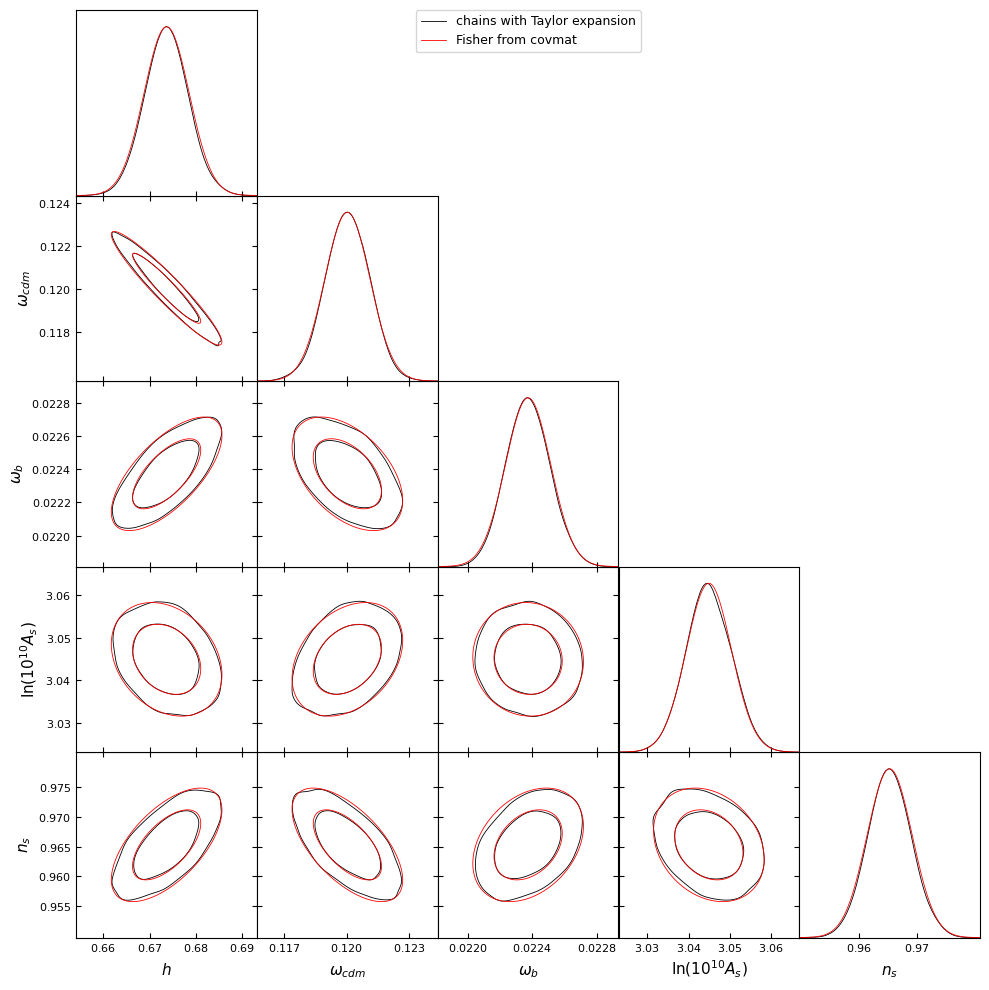

In [24]:
# Perfect agreement here, so it's "Fisher from likelihood" which is failing
plotting.plot_triangle([samples, precision_planck.to_covariance().clone(center=samples.mean(precision_planck.params()))],
                       labels=['chains with Taylor expansion', 'Fisher from covmat'])